In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [8]:
def log10_scale(x):
    linear = ((x <= np.e) & (x >= -np.e)) # to match the derivatives
    y = np.where(linear, 1, x) # to avoid np.log10 warnings
    y = np.abs(y)
    return np.where(linear, x / (np.e * np.log(10)), np.sign(x) * np.log10(y))

In [3]:
method = "tabsyn"
dataset = "datafusion"

In [42]:
df = pd.read_csv(f"synthetic/{dataset}/{method}_orig.csv")
df.sample(n=5).reset_index(drop=True).drop("dummy_binclass", axis=1).style.set_caption(method.upper())
# df.head()

,mcc_code,currency_rk,transaction_amt,customer_age,time_diff_days
0,17,1,-25.380466,0,0.163074
1,3,1,15522.208000,3,20.821594
2,7,1,-324.953460,2,0.064562
3,14,1,-4877.002400,1,4.558512
4,10,1,-1666.054200,1,1.053364


In [85]:
for length in (2,):
    (
        pd.read_csv(f"synthetic/datafusion_with_id/synth_{length}.csv")
        .drop(["user_id", "days_since_first_tx"], axis=1)
        .to_csv(f"synthetic/datafusion_with_id/synth_dropped_{length}.csv", index=False)
    )

In [86]:
for length in (2,):
    (
        pd.read_csv(f"synthetic/datafusion_with_id/synth_dropped_{length}.csv")
        .assign(transaction_amt=lambda df: log10_scale(df.transaction_amt))
        .to_csv(f"synthetic/datafusion_with_id/synth_dropped_tfed_{length}.csv", index=False)
    )

In [88]:
columns = ["transaction_amt", "time_diff_days", "mcc_code", "currency_rk", "customer_age"]

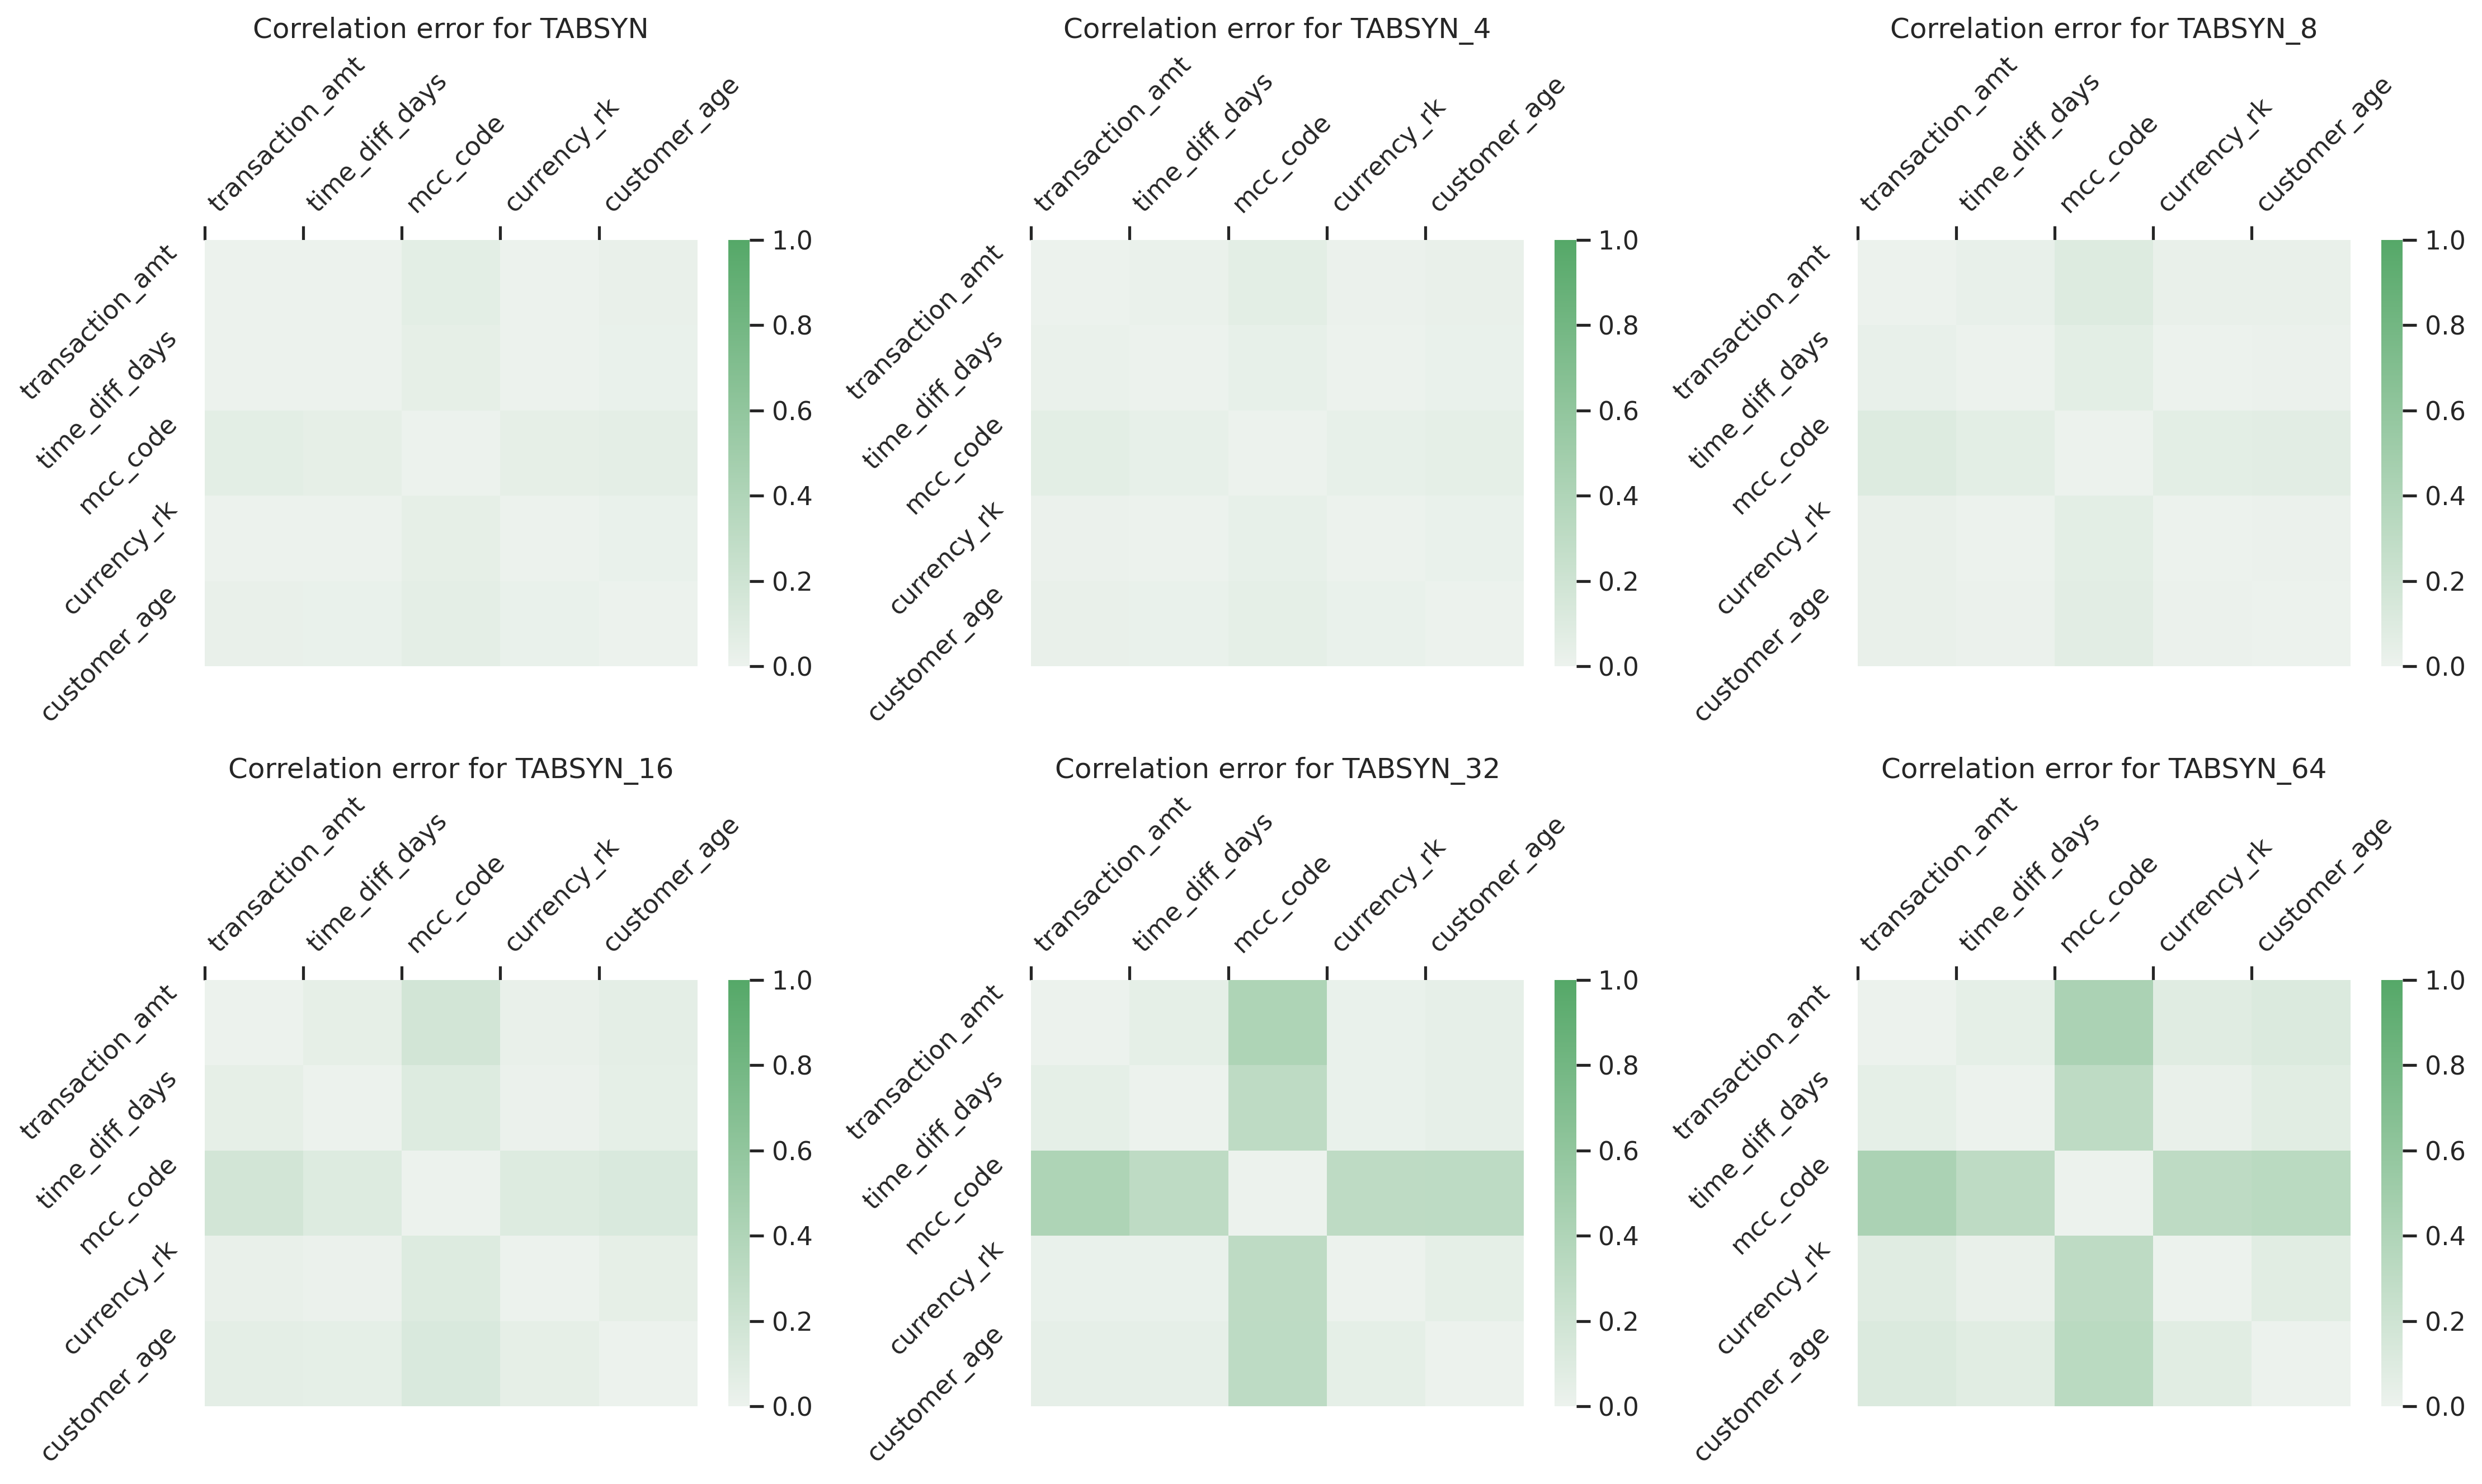

In [89]:
_, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=300, layout="tight")
axs = axs.flatten()

for length, ax in zip((1, 4, 8, 16, 32, 64), axs):
    if length == 1:
        method = "tabsyn"
    else:
        method = f"tabsyn_{length}"

    df = (
        pd.read_csv(f"eval/density/{dataset}/{method}/trend.csv", index_col=0, usecols=[0, 1, 2, 4])
        .pivot(index="Column 1", columns="Column 2", values="Score")
    )
    df.insert(0, 0, np.nan)
    df.loc[6] = np.nan
    df = df.fillna(0)
    
    corr = df.values
    corr += corr.T + np.eye(6)
    corr = 1 - corr
    corr = corr[:-1, :-1]
    
    sns.heatmap(corr, ax=ax, vmin=0, vmax=1, cmap=sns.color_palette("light:g", as_cmap=True))
    ax.set_xticks(list(range(5)))
    ax.set_xticklabels(columns, rotation=45, ha="left")
    ax.set_yticks(list(range(5)))
    ax.set_yticklabels(columns, rotation=45, va="top")
    ax.set_title(f"Correlation error for {method.upper()}")
    
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

plt.show()

# Plots

In [72]:
df_real = pd.read_csv(f"synthetic/datafusion/test.csv").sample(n=100_000, random_state=0)
df_tabsyn = pd.read_csv(f"synthetic/datafusion_with_id/synth_dropped_tfed_32.csv").sample(n=100_000, random_state=0)
# df_smote = pd.read_csv(f"synthetic/datafusion/smote.csv")

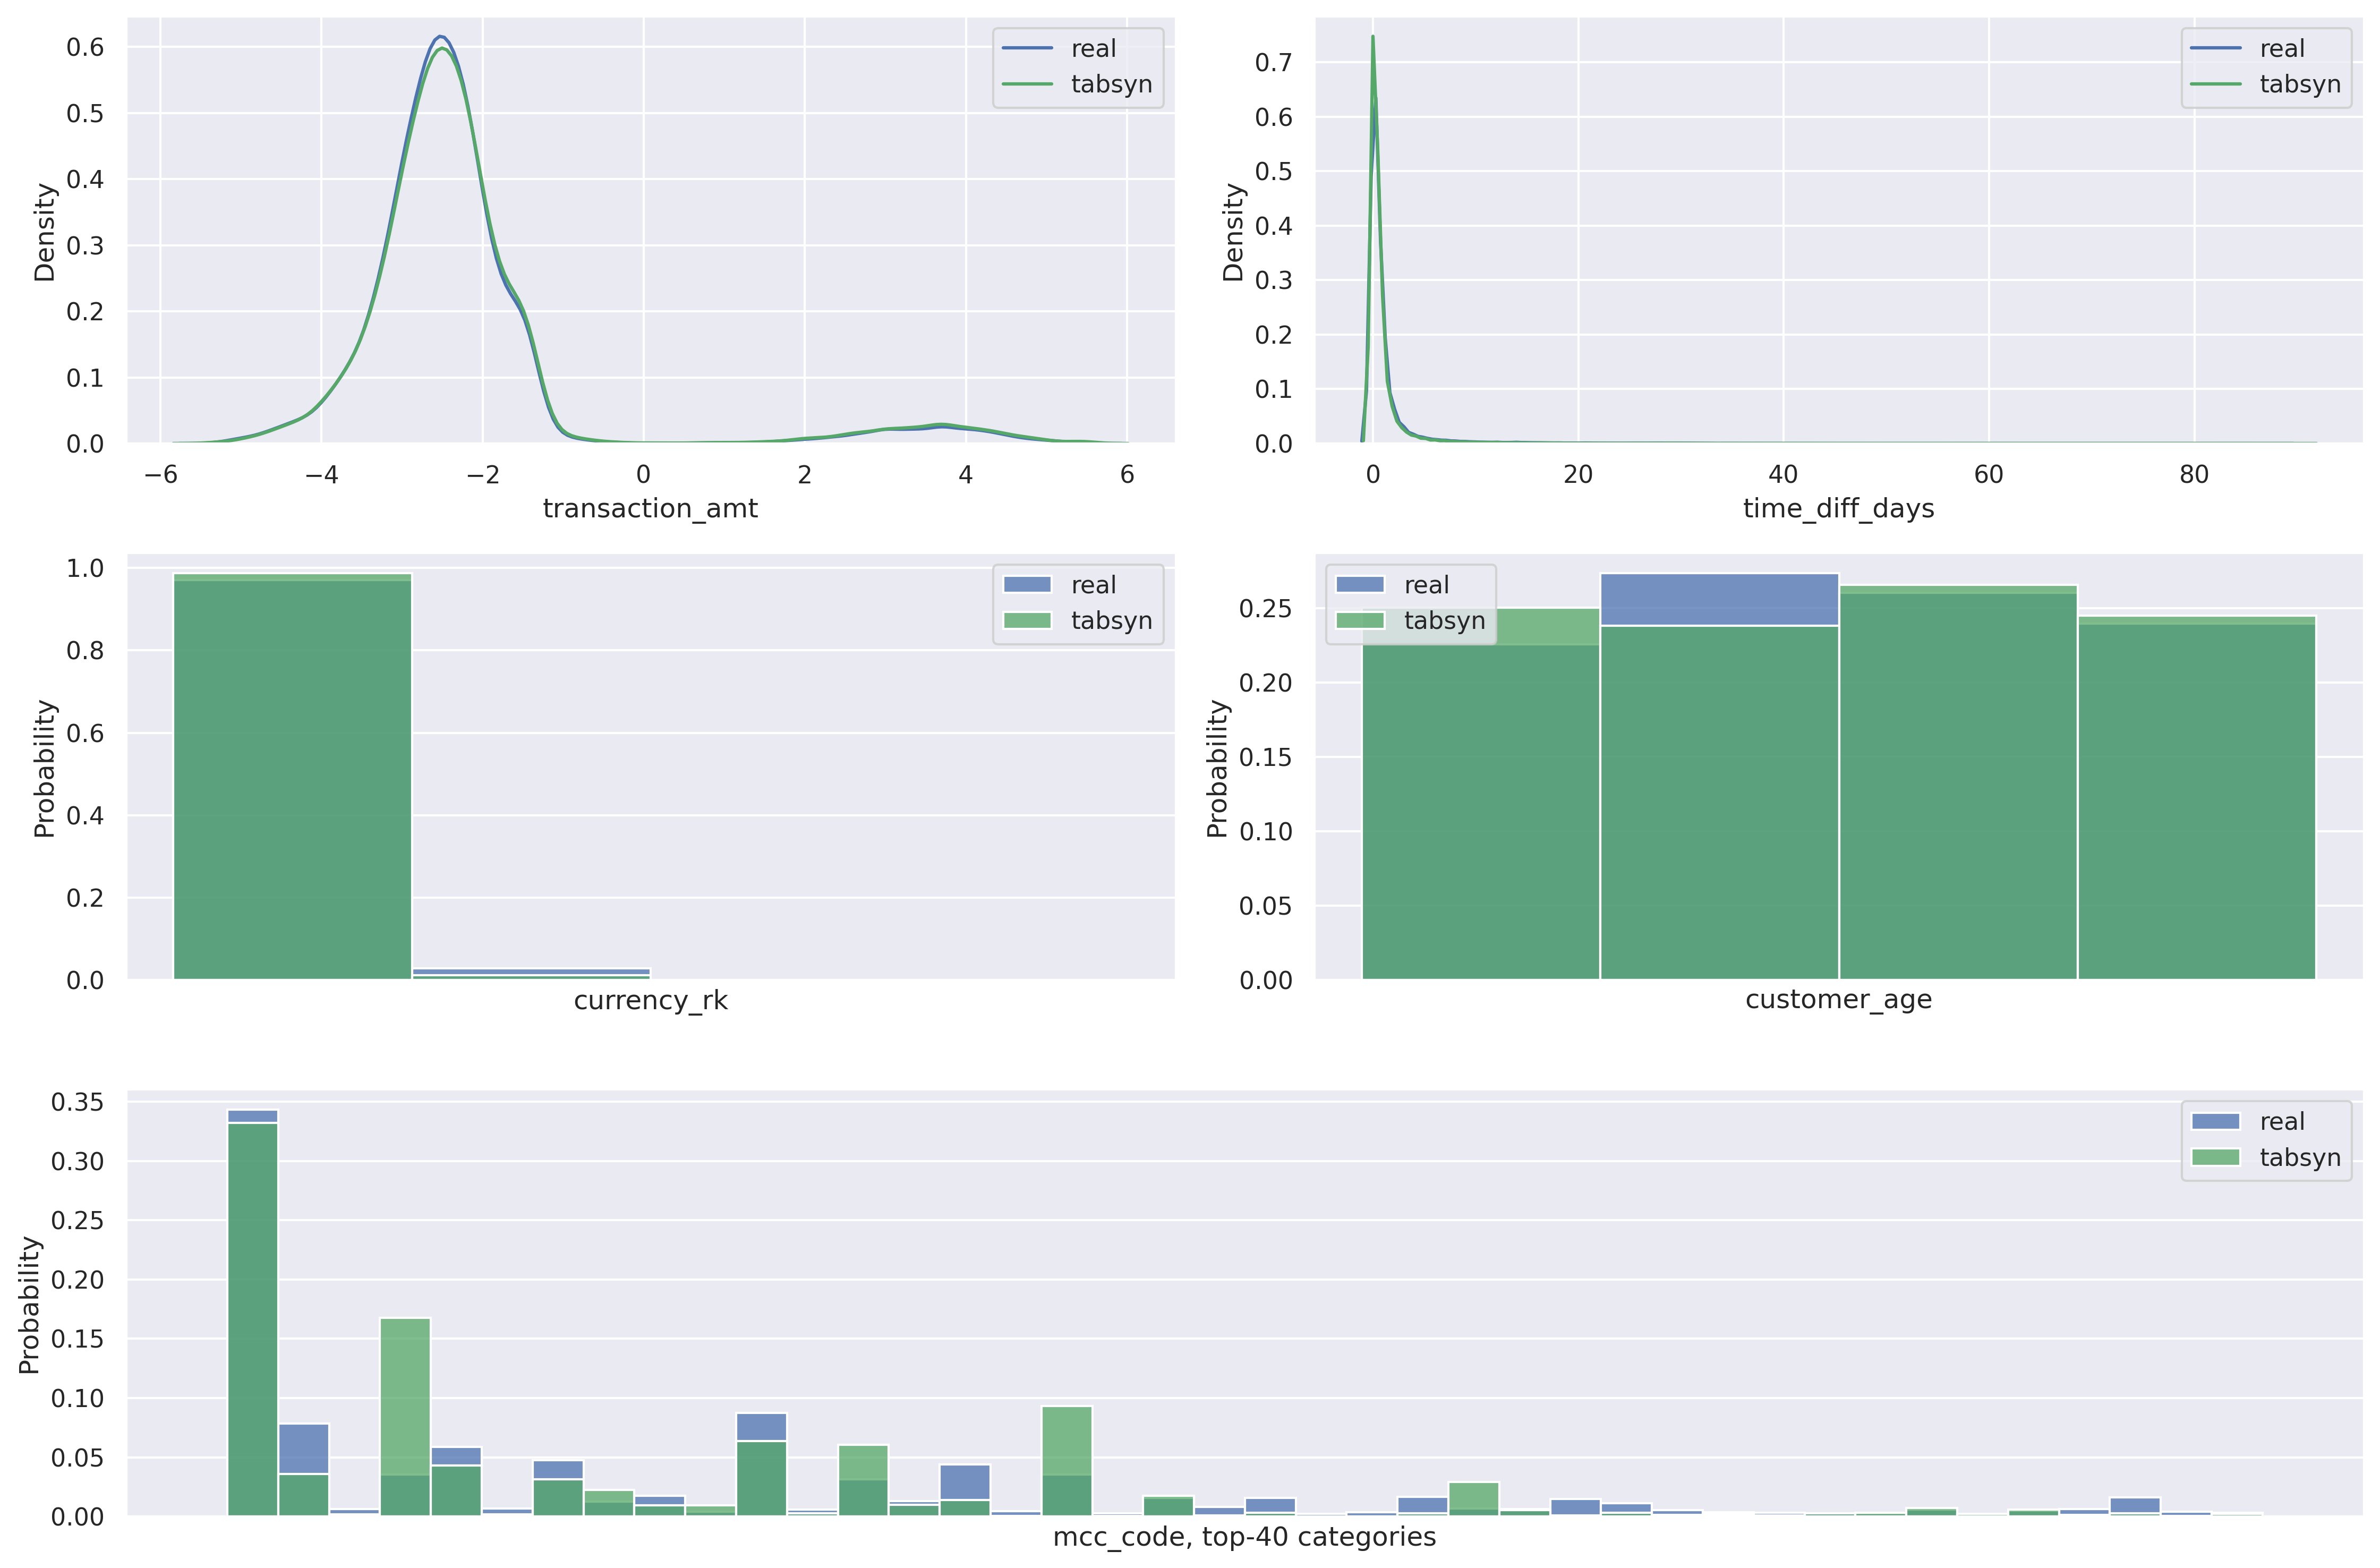

In [73]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10), dpi=300)
gs = axs[2, 0].get_gridspec()
for ax in axs[2]:
    ax.remove()
ax_union = fig.add_subplot(gs[2, :])

for i, feature in enumerate(("transaction_amt", "time_diff_days")):
    ax = axs[0][i]
    sns.kdeplot(df_real[feature], label="real", ax=ax, c="C0")
#     sns.kdeplot(df_smote[feature], label="smote", ax=ax, c="C1")
    sns.kdeplot(df_tabsyn[feature], label="tabsyn", ax=ax, c="C2")
    ax.legend()
    
for i, feature in enumerate(("currency_rk", "customer_age")):
    ax = axs[1][i]
    sns.histplot(df_real[feature].astype(str), label="real", ax=ax, stat="probability", discrete=True, color="C0")
#     sns.histplot(df_smote[feature].astype(str), label="smote", ax=ax, stat="probability", discrete=True, color="C1")
    sns.histplot(df_tabsyn[feature].astype(str), label="tabsyn", ax=ax, stat="probability", discrete=True, color="C2")
    ax.set_xticks([])
    ax.legend()
    
feature = "mcc_code"
ax = ax_union
n_top = 40
top = df_real[feature].value_counts()[:n_top].index

real = df_real[feature][df_real[feature].isin(top)].astype(str)
tabsyn = df_tabsyn[feature][df_tabsyn[feature].isin(top)].astype(str)
smote = df_smote[feature][df_smote[feature].isin(top)].astype(str)
sns.histplot(real, label="real", ax=ax, stat="probability", discrete=True, color="C0")
# sns.histplot(smote, label="smote", ax=ax, stat="probability", discrete=True, color="C1")
sns.histplot(tabsyn, label="tabsyn", ax=ax, stat="probability", discrete=True, color="C2")
ax.set_xticks([])
ax.set_xlabel(f"mcc_code, top-{n_top} categories")
ax.legend()
    
fig.tight_layout()
plt.show()

# Amount transform

In [104]:
name = "real"
df = pd.read_csv(f"synthetic/datafusion/{name}_orig.csv")
df["transaction_amt"] = log10_scale(df["transaction_amt"])
df.to_csv(f"synthetic/datafusion/{name}.csv", index=False)

In [107]:
df = pd.read_csv("synthetic/datafusion/test_orig.csv")
df

,mcc_code,currency_rk,transaction_amt,customer_age,time_diff_days,dummy_binclass
0,1,1,-135.662120,2,0.322581,1
1,65,1,-729.473940,2,0.124456,1
2,2,1,-100.566910,1,1.055567,1
3,48,0,-2516.684300,1,5.997917,1
4,11,1,-28.237514,2,0.531701,1
...,...,...,...,...,...,...
1297898,30,1,-184.752300,1,1.940405,1
1297899,4,1,-221.334410,0,1.112824,0
1297900,0,1,22819.123000,3,0.357870,1
1297901,8,1,-82.135450,1,0.007350,1


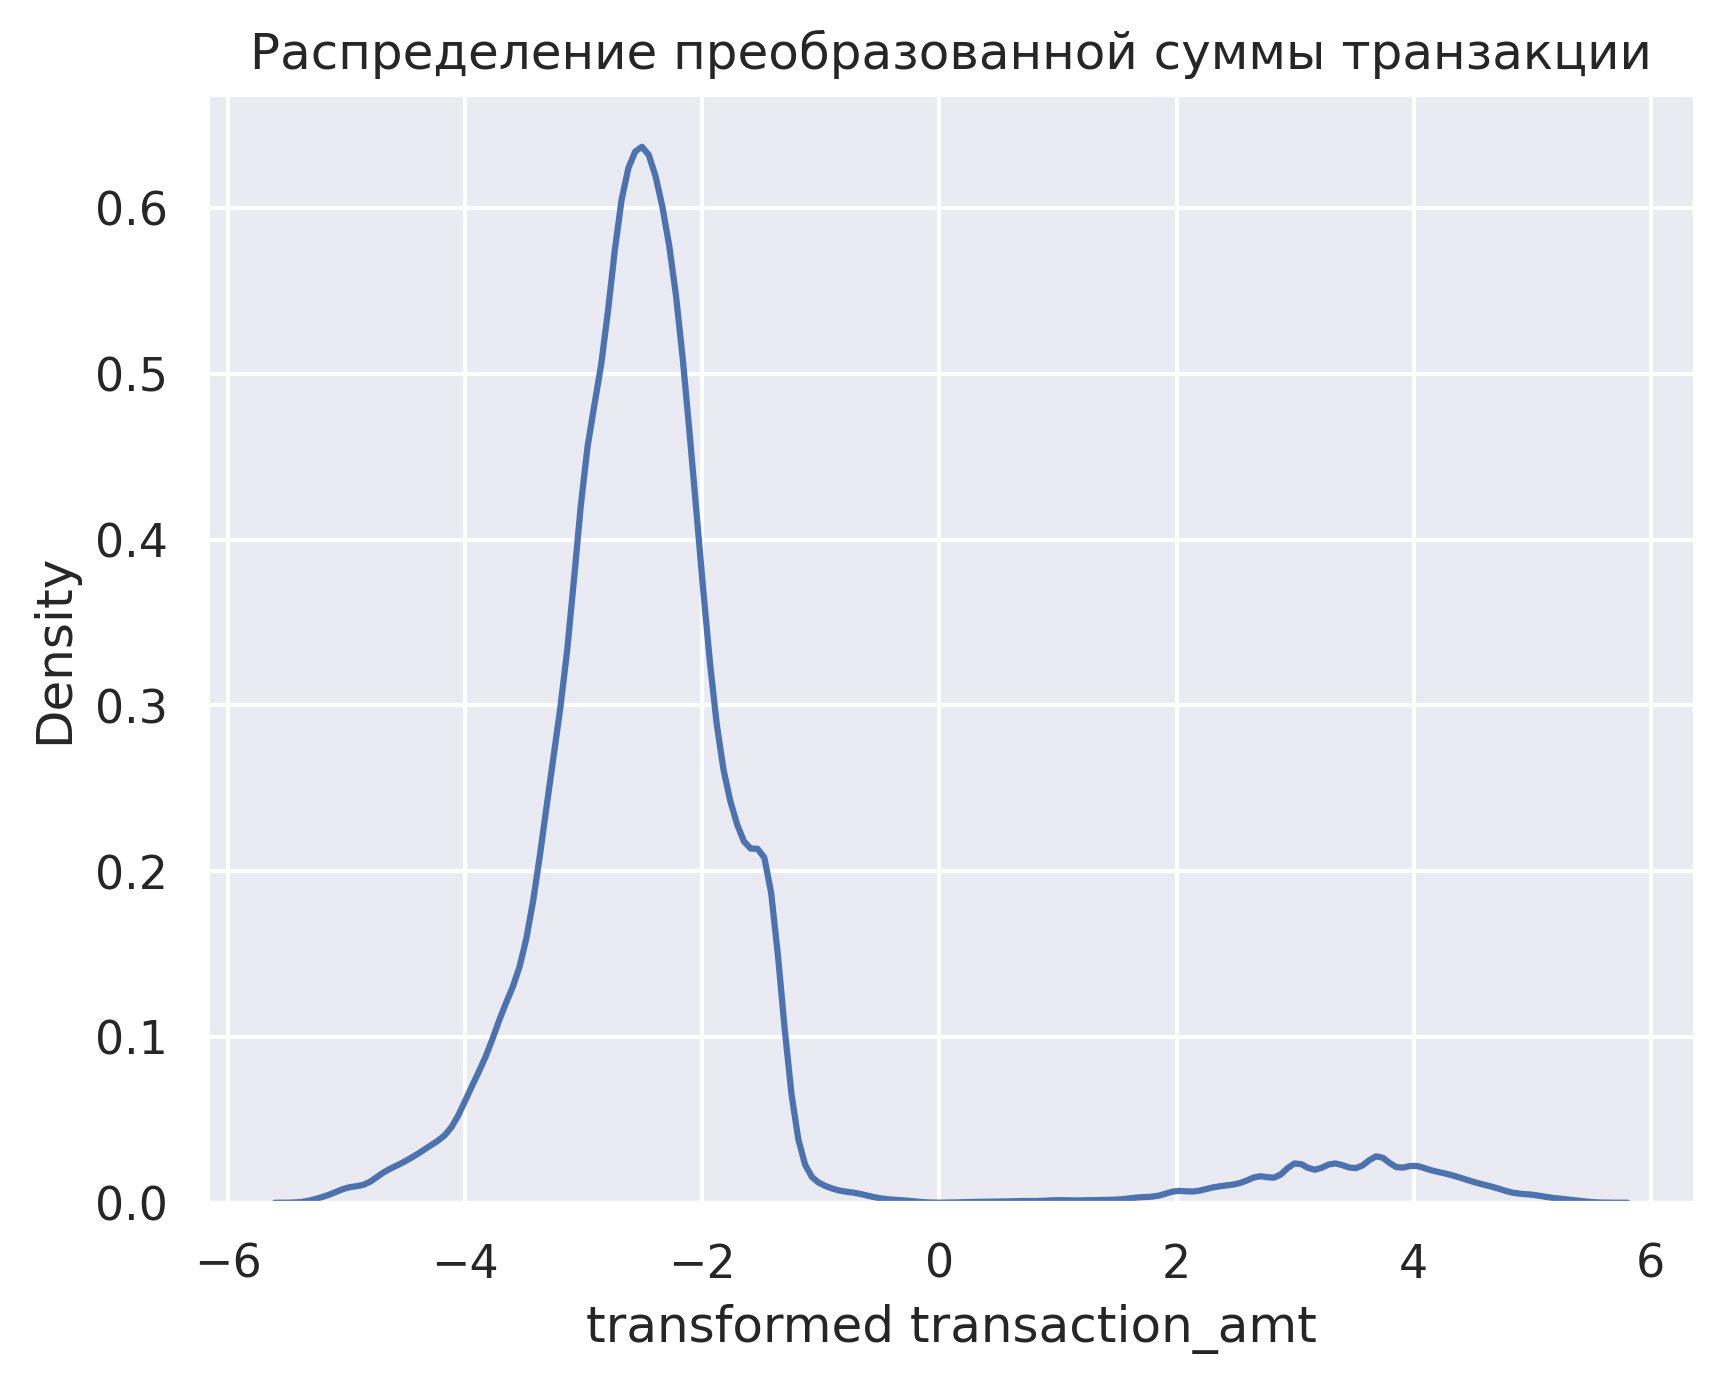

In [112]:
_, ax = plt.subplots(dpi=300)
sns.kdeplot(log10_scale(df.transaction_amt))
ax.set_title("Распределение преобразованной суммы транзакции")
ax.set_xlabel("transformed transaction_amt")
plt.show()

# Plots

## Amnt by MCC

In [20]:
df_real = pd.read_csv(f"synthetic/datafusion/test.csv").sample(n=100_000, random_state=0)
df_tabsyn = pd.read_csv(f"synthetic/datafusion/tabsyn.csv").sample(n=100_000, random_state=0)
df_smote = pd.read_csv(f"synthetic/datafusion/smote.csv")

In [21]:
df = pd.concat((
    df_real.assign(method="real"),
    df_tabsyn.assign(method="tabsyn"),
    df_smote.assign(method="smote"),
), axis=0)

In [22]:
n_top = 15
top = df_real["mcc_code"].value_counts().iloc[:n_top].index
df = df.query("mcc_code.isin(@top)")

In [23]:
df

,mcc_code,currency_rk,transaction_amt,customer_age,time_diff_days,dummy_binclass,method
1265823,1,1,-2.577347,1,0.141076,1,real
506214,4,1,-1.565121,3,0.866319,1,real
475987,8,1,-1.772468,3,0.011863,1,real
1045657,1,1,-2.571802,2,2.027963,1,real
1129274,4,1,-2.144458,3,0.873831,1,real
...,...,...,...,...,...,...,...
99995,4,1,-2.133375,1,0.154071,1,smote
99996,0,1,3.736589,2,0.017665,1,smote
99997,4,1,-2.958435,2,6.695593,1,smote
99998,11,1,-1.695978,1,0.046054,1,smote


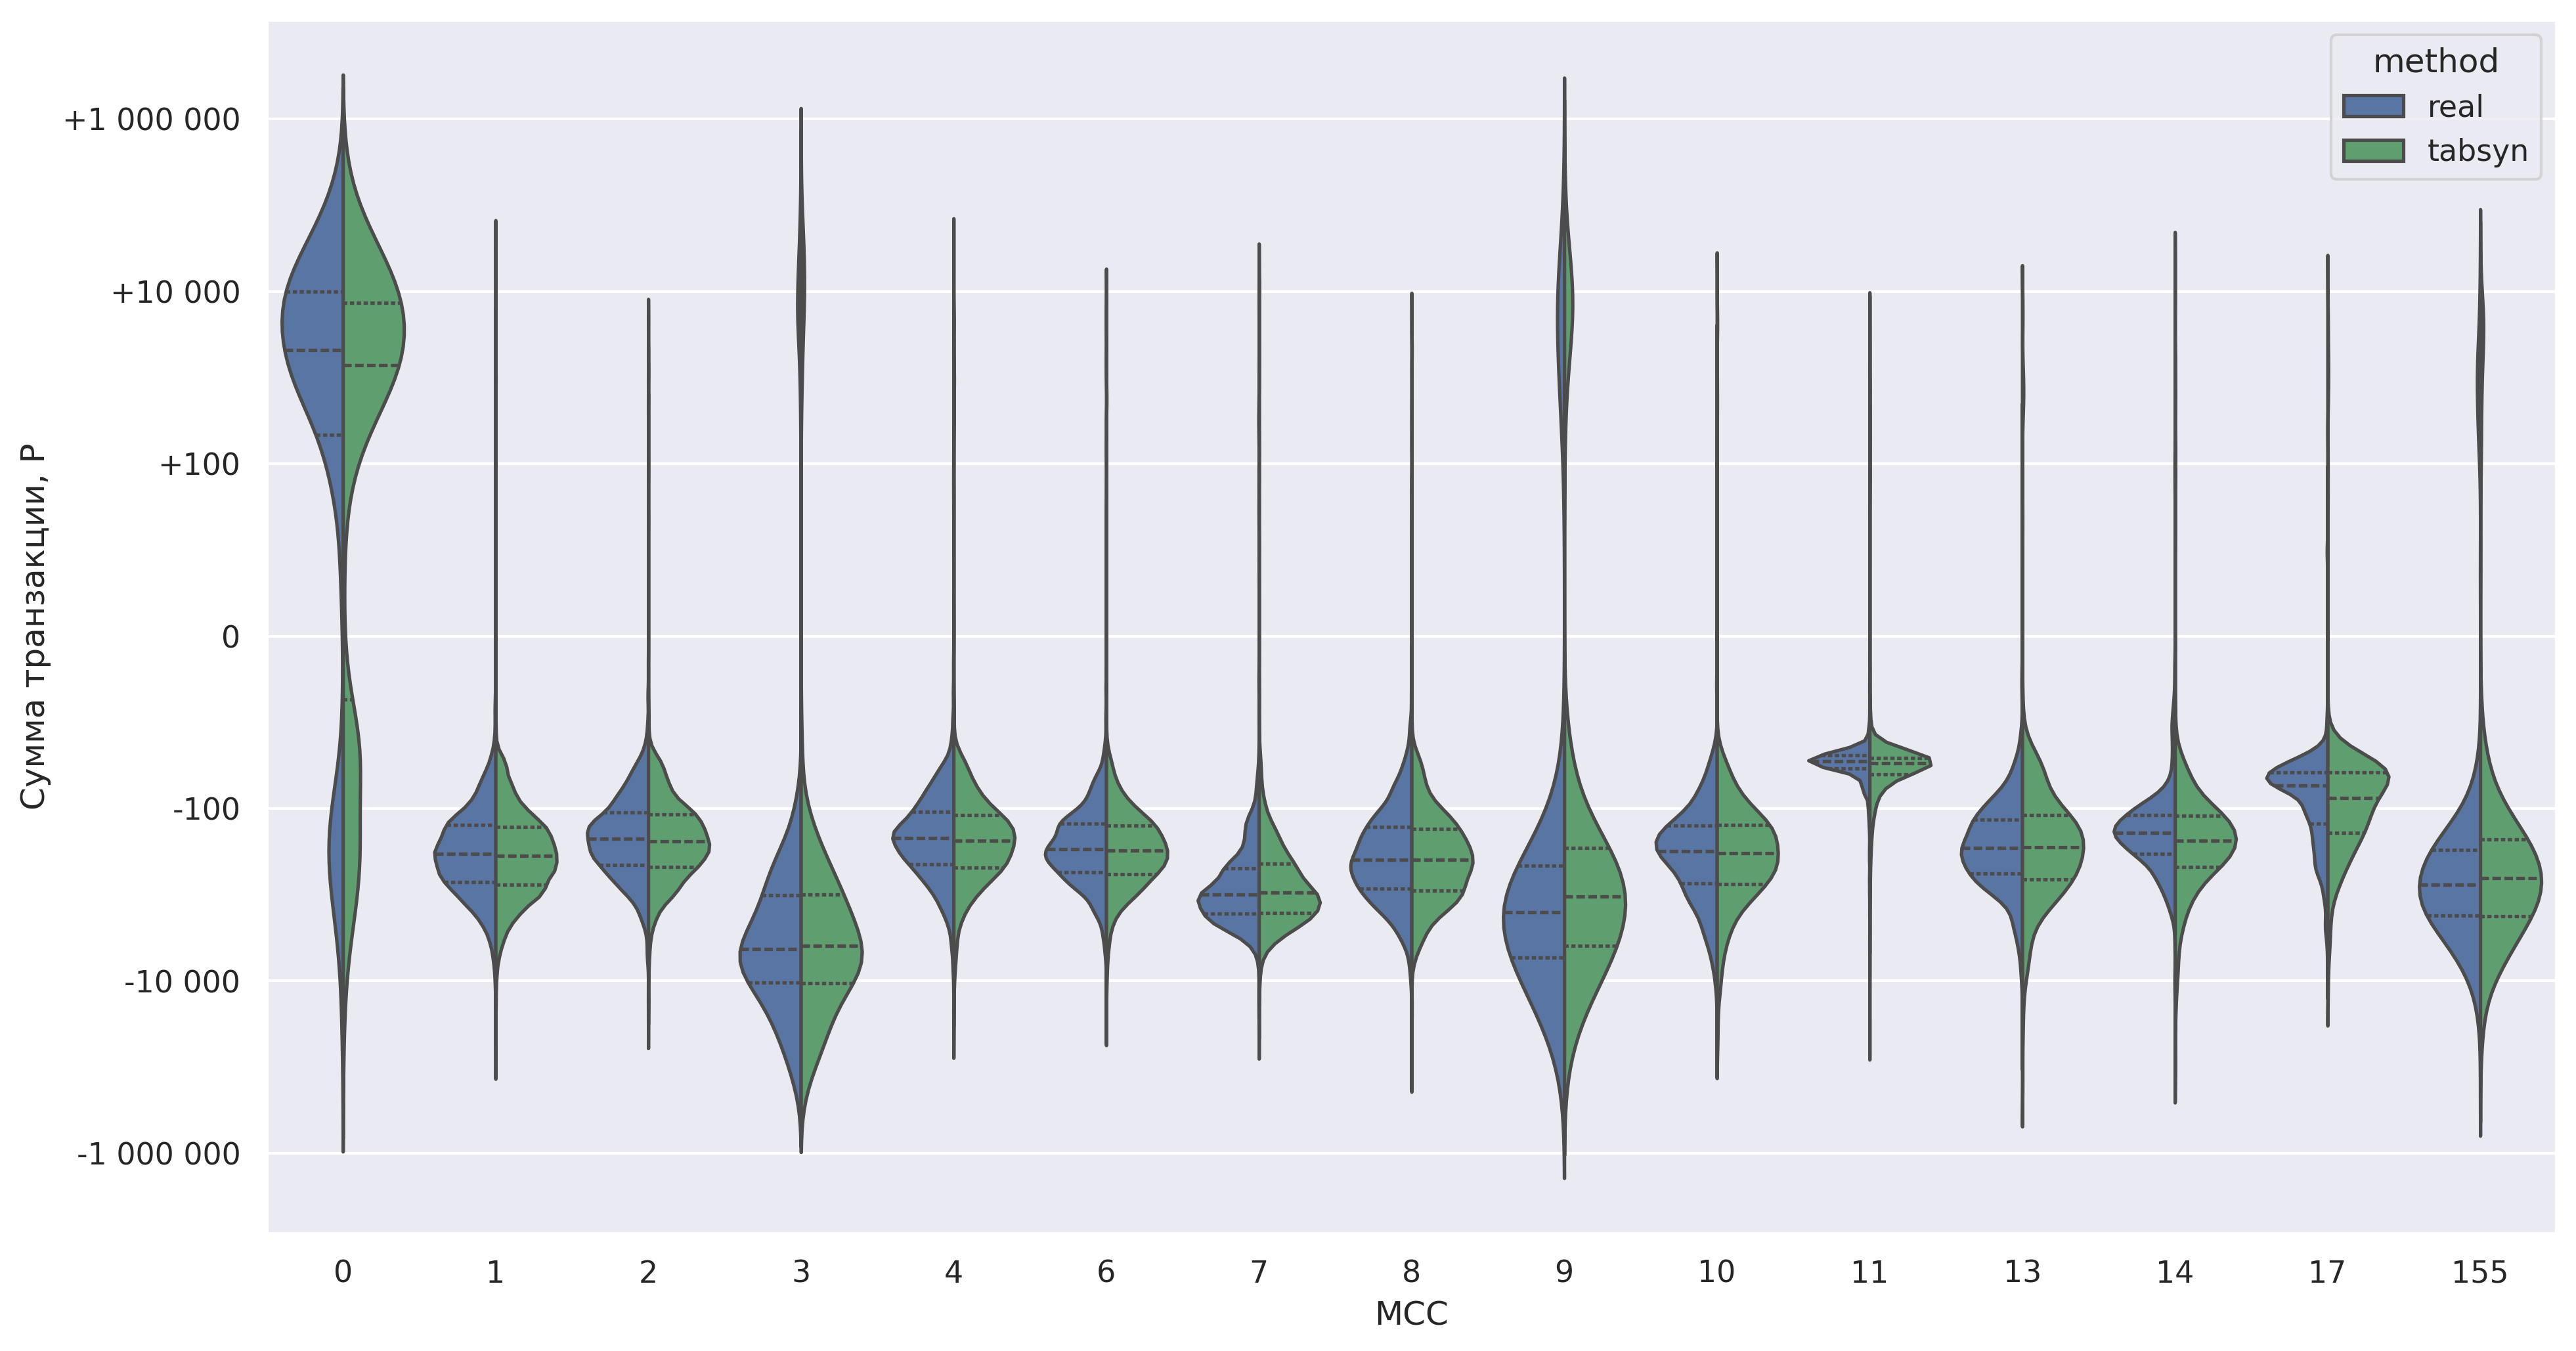

In [25]:
_, ax = plt.subplots(figsize=(15, 8), dpi=300)
sns.violinplot(
    df.query("method != 'smote'"),
    x="mcc_code",
    y="transaction_amt", 
    hue="method",
    split=True,
    inner="quart",
    density_norm="width",
    palette=dict(real="C0", smote="C1", tabsyn="C2"),
)
ax.set_yticks(np.linspace(-6, 6, 7))
ax.set_yticklabels(["-1 000 000", "-10 000", "-100", "0", "+100", "+10 000", "+1 000 000"])
ax.set_ylabel("Сумма транзакции, Р")
ax.set_xlabel("MCC")
plt.show()

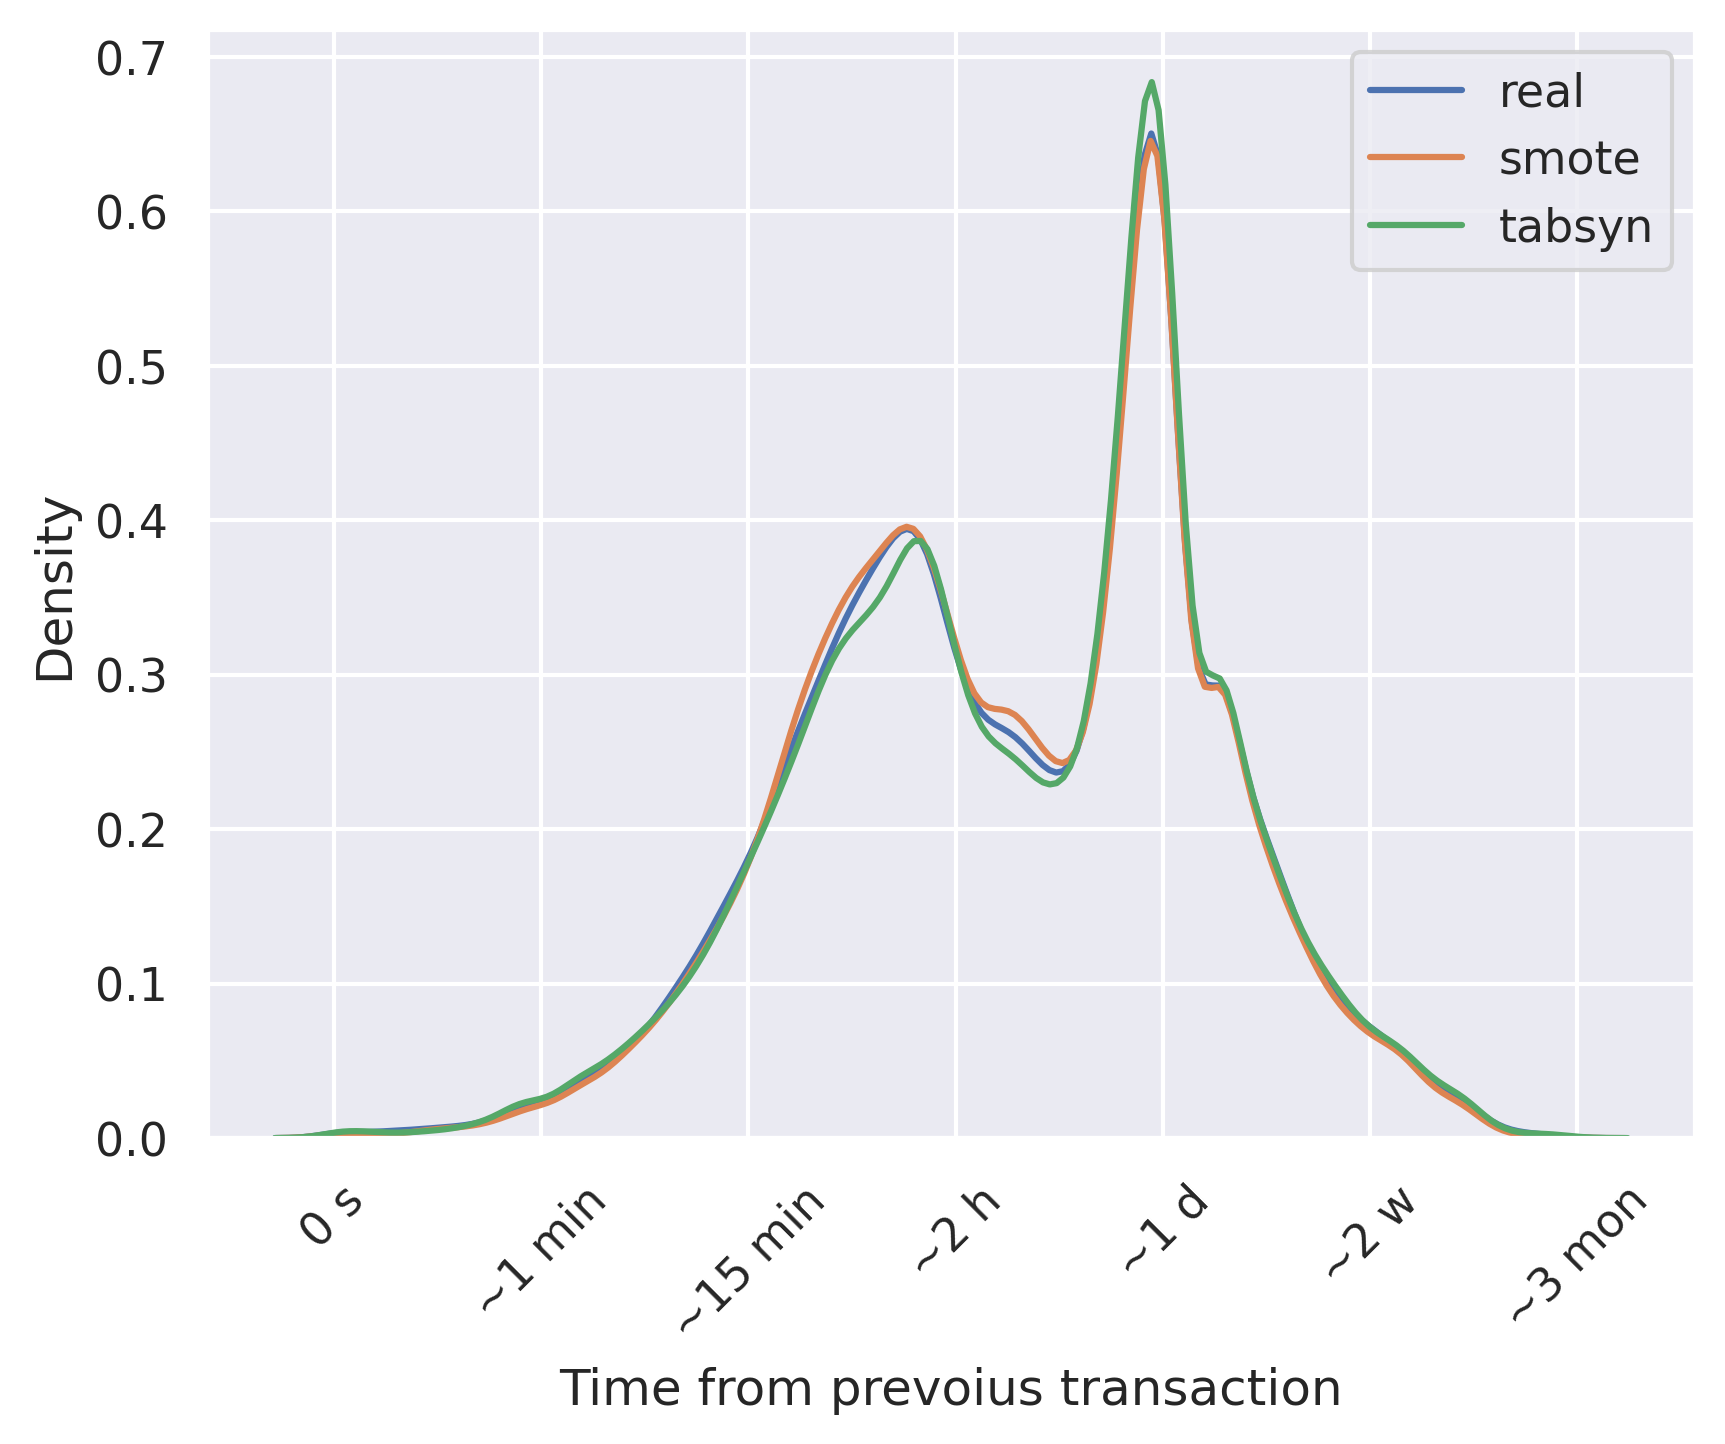

In [101]:
_, ax = plt.subplots(dpi=300)

sns.kdeplot(np.log10(0.0001 + df_real.time_diff_days), label="real", c="C0")
sns.kdeplot(np.log10(0.0001 + df_smote.time_diff_days), label="smote", c="C1")
sns.kdeplot(np.log10(0.0001 + df_tabsyn.time_diff_days), label="tabsyn", c="C2")

ax.legend()
ax.set_xticks(np.arange(-4, 3))
ax.set_xticklabels(["0 s", "~1 min", "~15 min", "~2 h", "~1 d", "~2 w", "~3 mon"], rotation=45)
ax.set_xlabel("Time from prevoius transaction")

plt.show()

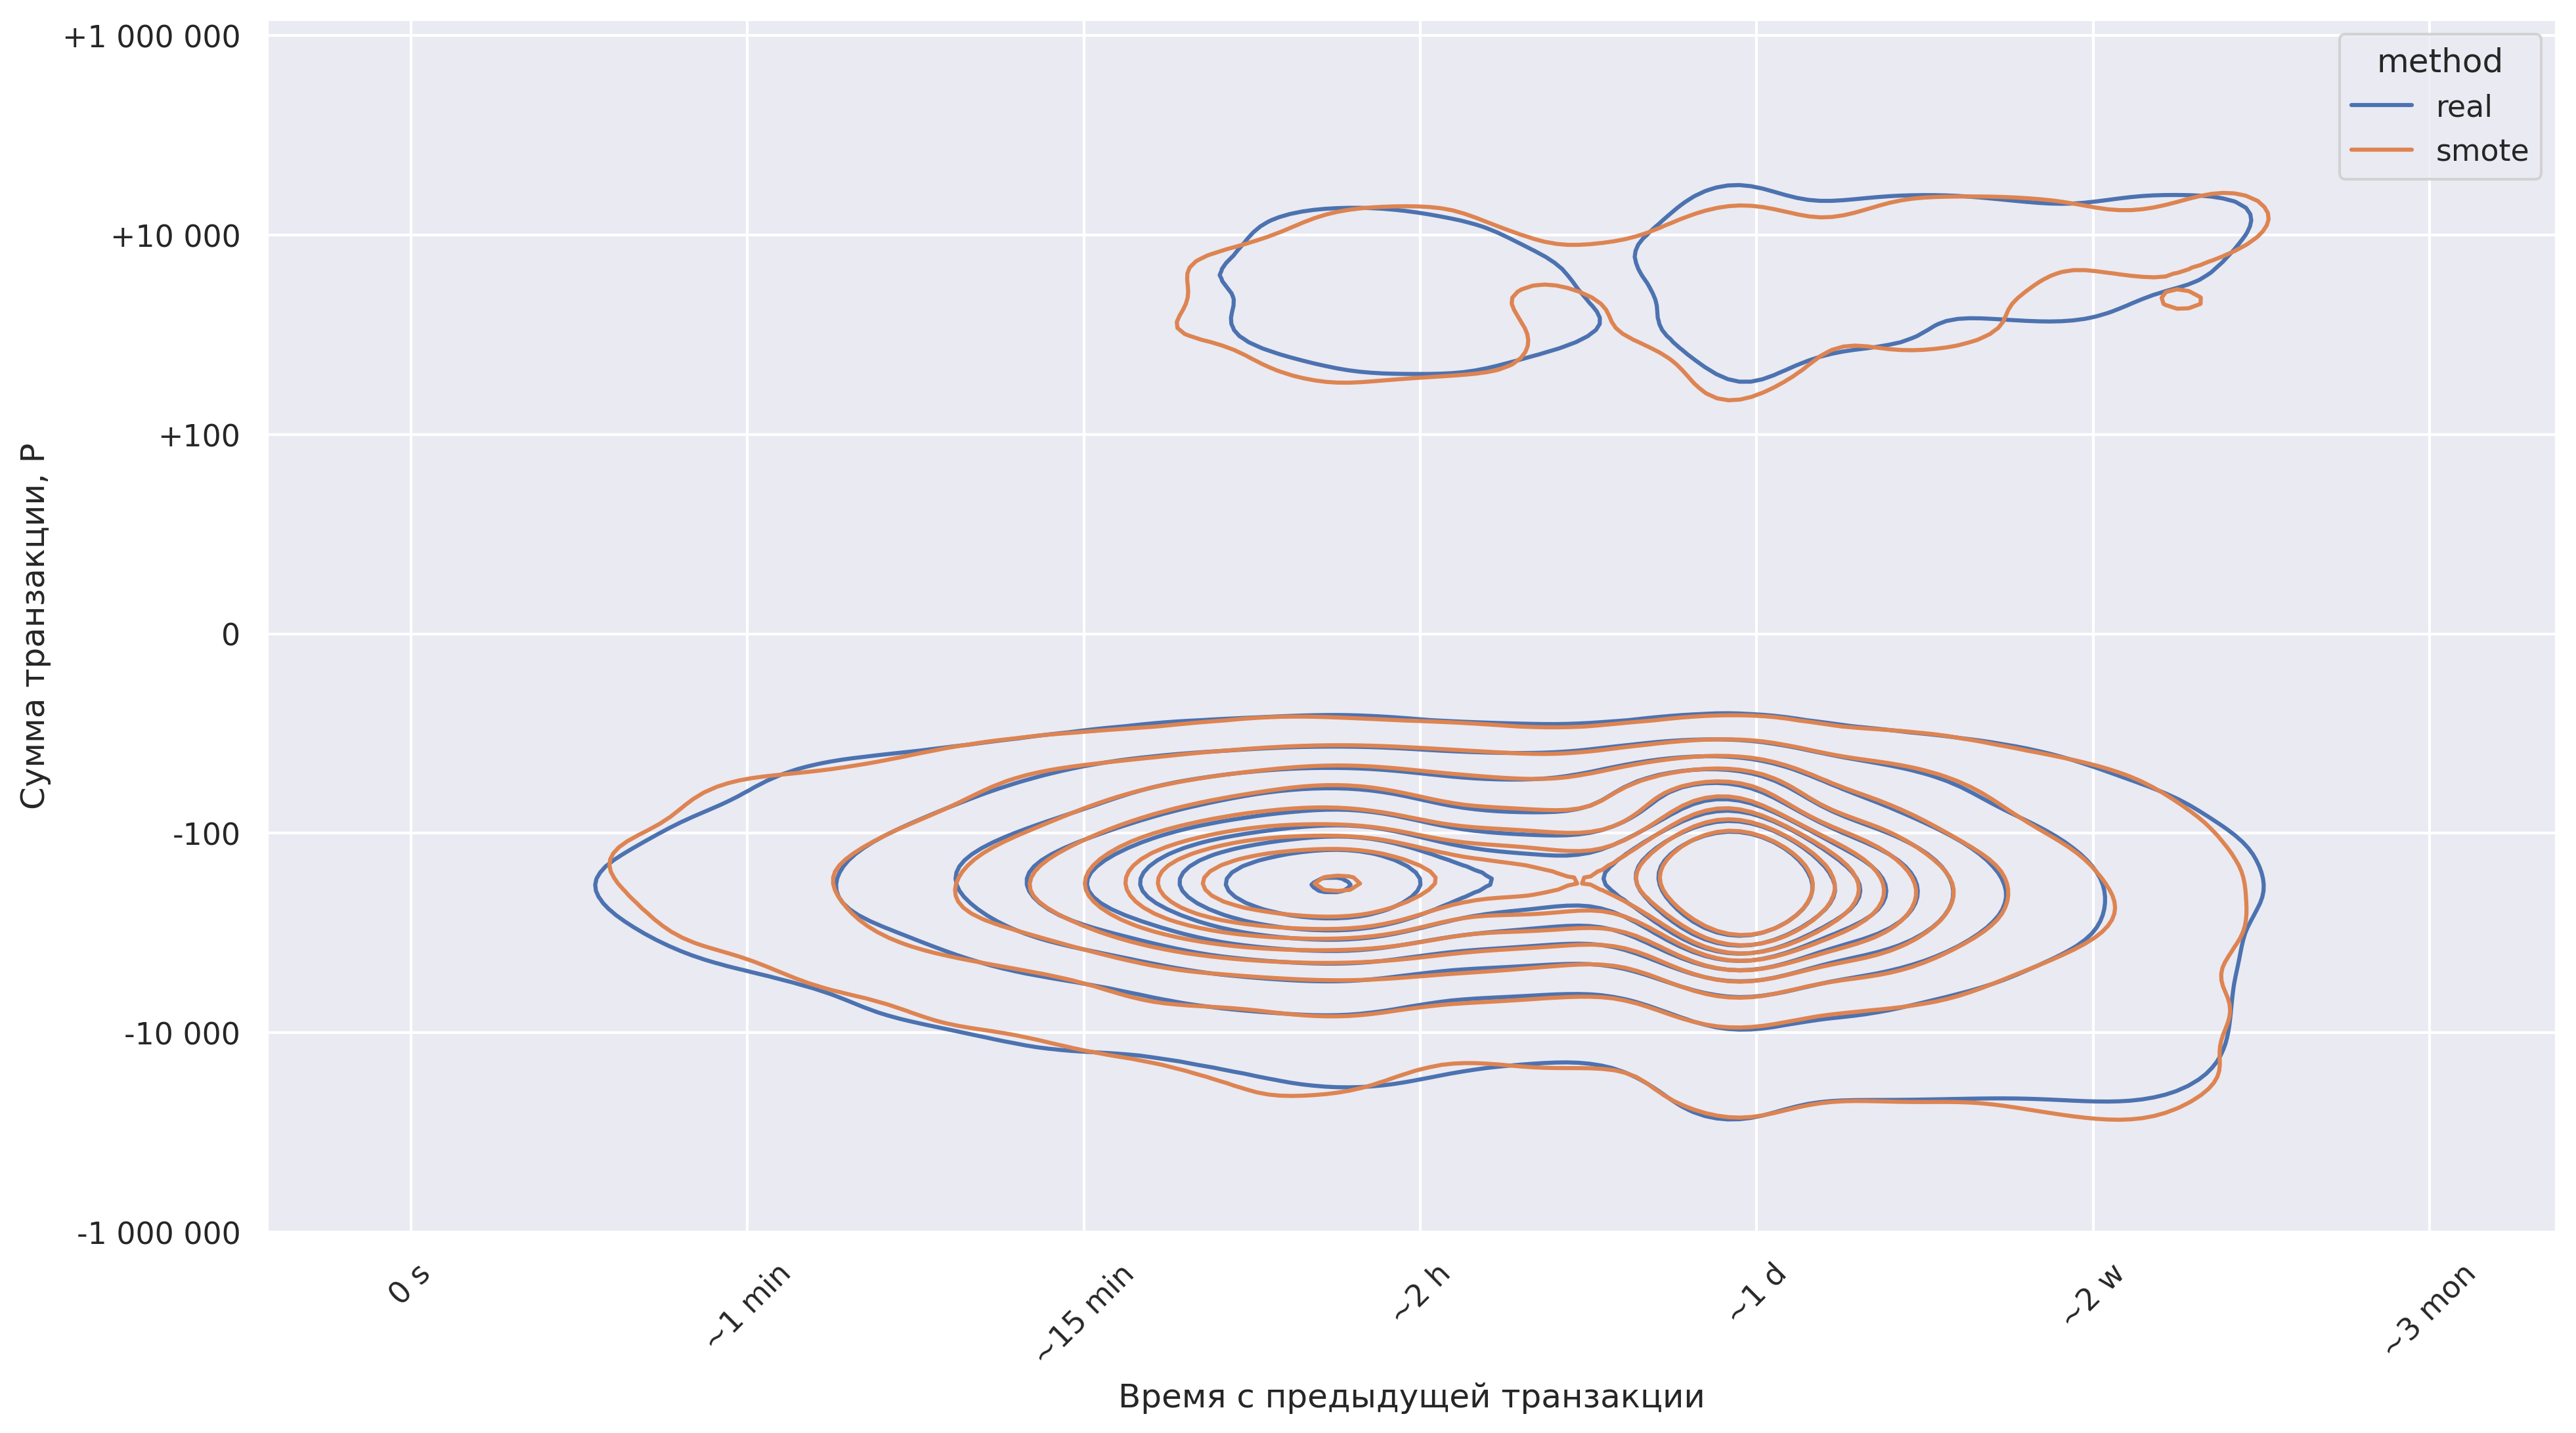

In [32]:
_, ax = plt.subplots(figsize=(15, 8), dpi=300)

sns.kdeplot(
    df.assign(
        span=lambda df: np.log10(0.0001 + df.time_diff_days)
    ).query("method != 'tabsyn'"),
    x="span",
    y="transaction_amt", 
    hue="method",
    palette=dict(real="C0", smote="C1", tabsyn="C2"),
)

ax.set_yticks(np.linspace(-6, 6, 7))
ax.set_yticklabels(["-1 000 000", "-10 000", "-100", "0", "+100", "+10 000", "+1 000 000"])
ax.set_ylabel("Сумма транзакции, Р")

ax.set_xticks(np.arange(-4, 3))
ax.set_xticklabels(["0 s", "~1 min", "~15 min", "~2 h", "~1 d", "~2 w", "~3 mon"], rotation=45)
ax.set_xlabel("Время с предыдущей транзакции")

plt.show()

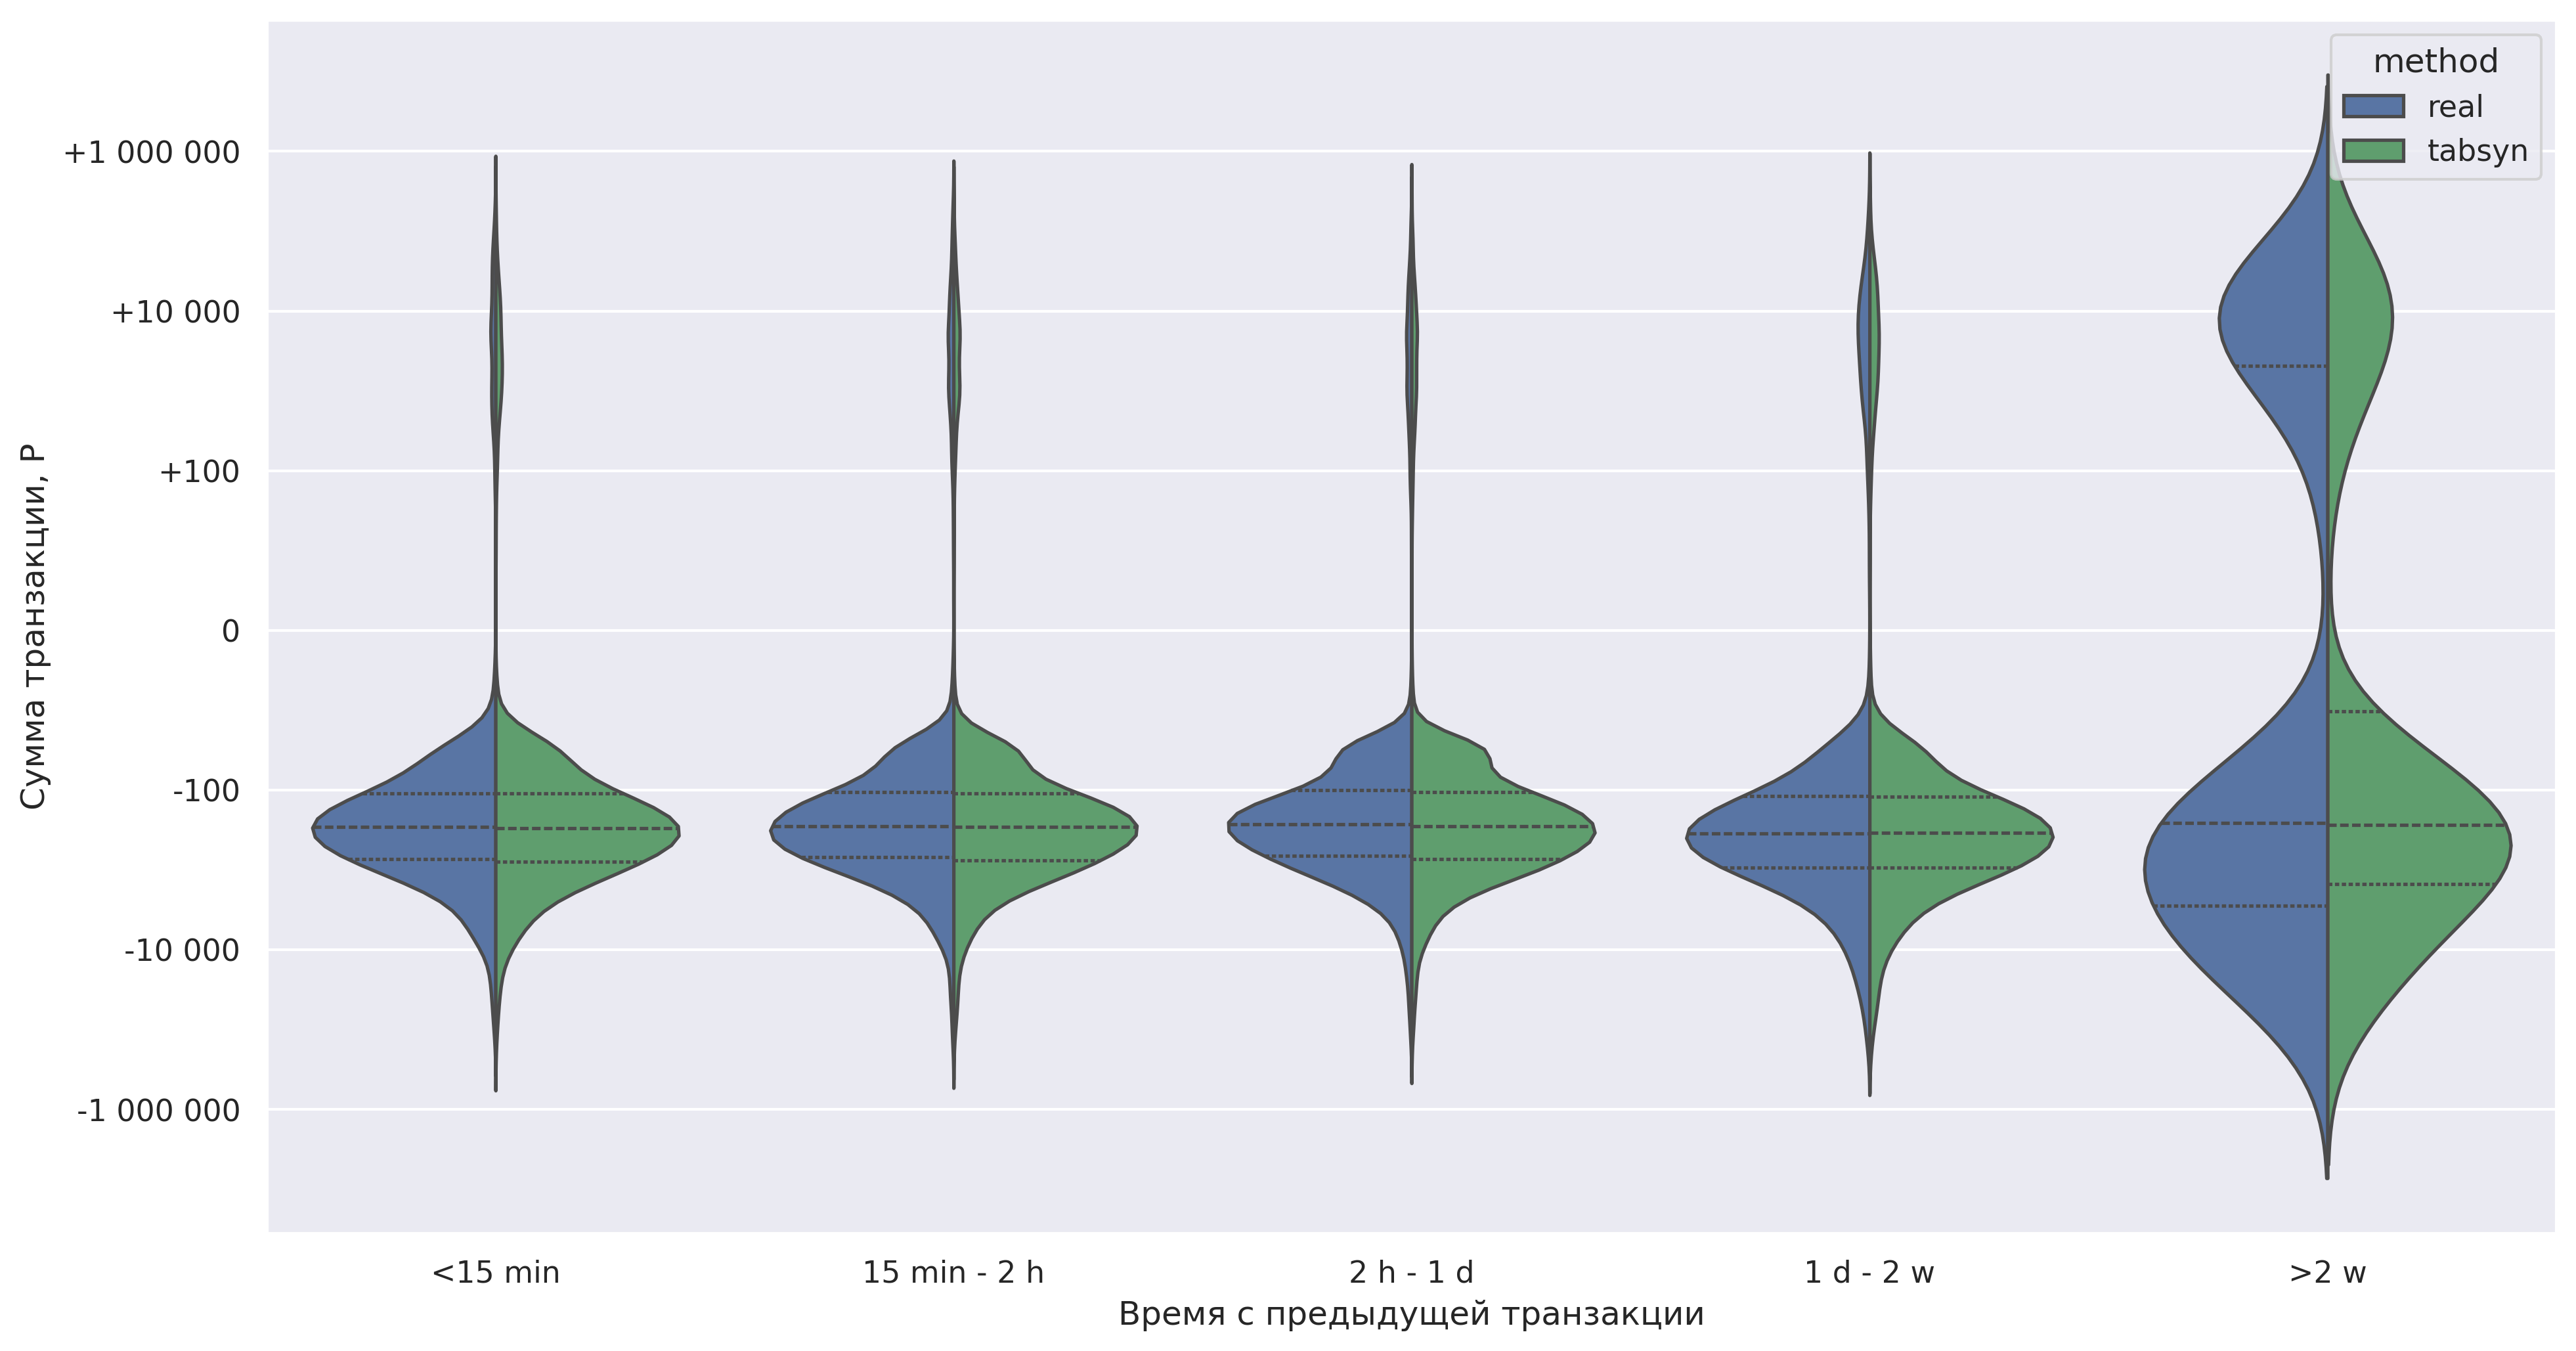

In [33]:
_, ax = plt.subplots(figsize=(15, 8), dpi=300)
sns.violinplot(
    df.assign(
        span=pd.cut(
            df.time_diff_days, 
            [-1, 1 / (24 * 4), 1 / 12, 1, 14, 1000],
            labels=["<15 min", "15 min - 2 h", "2 h - 1 d", "1 d - 2 w", ">2 w"],
        )
    ).query("method != 'smote'"),
    x="span",
    y="transaction_amt", 
    hue="method",
    split=True,
    inner="quart",
    density_norm="width",
    palette=dict(real="C0", smote="C1", tabsyn="C2"),
)
ax.set_yticks(np.linspace(-6, 6, 7))
ax.set_yticklabels(["-1 000 000", "-10 000", "-100", "0", "+100", "+10 000", "+1 000 000"])
ax.set_ylabel("Сумма транзакции, Р")
ax.set_xlabel("Время с предыдущей транзакции")
plt.show()